In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

sp500 = yf.download('^GSPC', start='1990-01-01', end='2024-03-18')
sp500_future = yf.download('ES=F', start='1990-01-01', end='2024-03-18')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


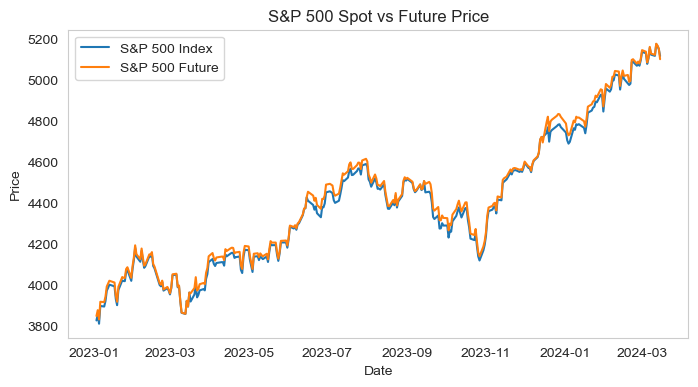

In [2]:
plt.figure(figsize=(8, 4))
plt.plot(sp500['Close']['2023':], label='S&P 500 Index')
plt.plot(sp500_future['Close']['2023':], label='S&P 500 Future')
plt.title('S&P 500 Spot vs Future Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(False)
plt.legend()
plt.show()

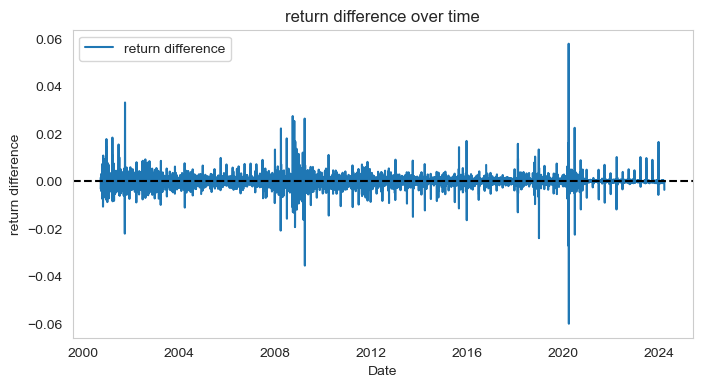

In [3]:
price_diff = sp500_future['Close'].pct_change() - sp500['Close'].pct_change()
plt.figure(figsize=(8, 4))
plt.plot(price_diff, label='return difference')
plt.title('return difference over time')
plt.xlabel('Date')
plt.ylabel('return difference')
plt.axhline(0, color='black', linestyle='--') 
plt.legend()
plt.grid(False)
plt.show()

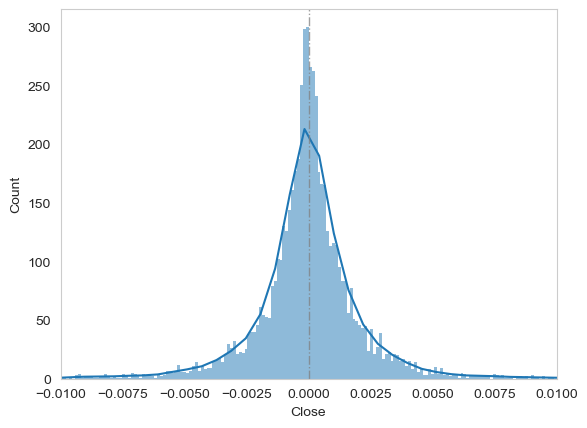

In [4]:
import seaborn as sns
sns.histplot(
    price_diff,
    bins = 1000,
    edgecolor = 'none',
    kde = True
)
plt.grid(False)
plt.xlim(
    [-0.01, 0.01]
)
plt.axvline(0, color = 'gray', lw = 1, ls = '-.', alpha = 0.75)
plt.show()

#### 선물의 가격은 시장의 기대(Expectation)을 반영할까?

In [5]:
future_ret = sp500_future['Close'].pct_change()
ret = sp500['Close'].pct_change()

In [6]:
matrix = pd.concat([
    ret, future_ret
], axis = 1)
matrix.columns = ['underline','futures']
matrix.fillna(0, inplace = True)

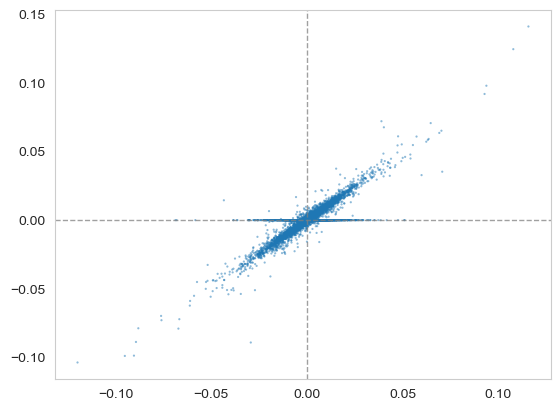

In [7]:
plt.scatter(
    matrix['underline'],
    matrix['futures'],
    marker = '.',
    s = 10,
    alpha = 0.5,
    edgecolor = 'none'
)
plt.axhline(0, color = 'gray', ls = '--', lw = 1, alpha = 0.75)
plt.axvline(0, color = 'gray', ls = '--', lw = 1, alpha = 0.75)
plt.grid(False)
plt.show()

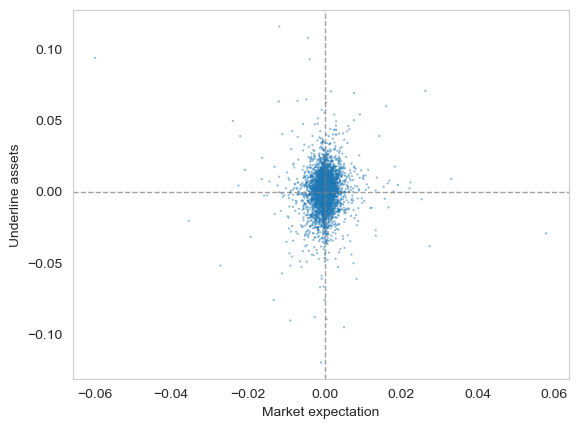

In [9]:
plt.scatter(
    (matrix['futures'] - matrix['underline']).shift(1)['2001':],
    matrix['underline']['2001':],
    marker = '.',
    s = 10,
    alpha = 0.5,
    edgecolor = 'none'
)
plt.axhline(0, color = 'gray', ls = '--', lw = 1, alpha = 0.75)
plt.axvline(0, color = 'gray', ls = '--', lw = 1, alpha = 0.75)
plt.ylabel('Underline assets')
plt.xlabel('Market expectation')
plt.grid(False)
plt.show()

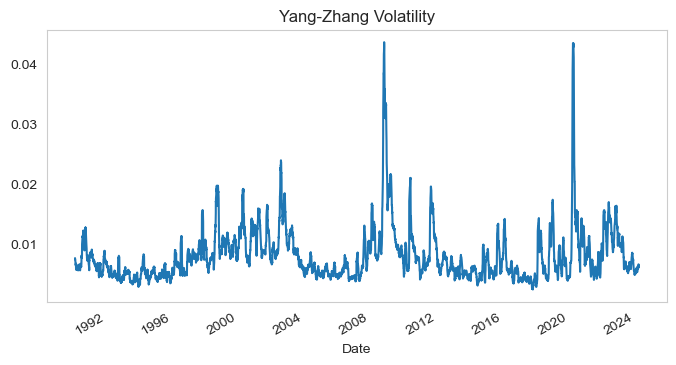

In [10]:
from FinancialMachineLearning.features.volatility import *

yang_zhang_volatility(sp500).plot(
    figsize = (8, 4),
    title = 'Yang-Zhang Volatility',
    grid = False
)
plt.show()

In [11]:
matrix

,underline,futures
Date,,
1990-01-02,0.000000,0.000000
1990-01-03,-0.002586,0.000000
1990-01-04,-0.008613,0.000000
1990-01-05,-0.009756,0.000000
1990-01-08,0.004514,0.000000
...,...,...
2024-03-11,-0.001122,-0.001170
2024-03-12,0.011202,0.010589
2024-03-13,-0.001925,-0.001787


In [12]:
matrix = pd.concat(
    [matrix, yang_zhang_volatility(sp500)], axis = 1
)
matrix.columns = ['underline', 'futures', 'volatility']

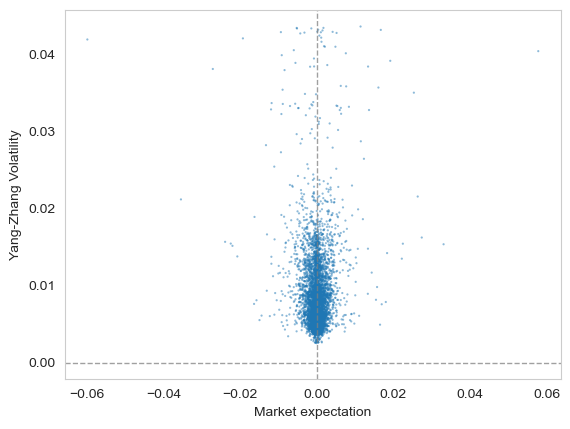

In [14]:
plt.scatter(
    (matrix['futures'] - matrix['underline']).shift(1)['2001':],
    matrix['volatility']['2001':],
    marker = '.',
    s = 10,
    alpha = 0.5,
    edgecolor = 'none'
)
plt.axhline(0, color = 'gray', ls = '--', lw = 1, alpha = 0.75)
plt.axvline(0, color = 'gray', ls = '--', lw = 1, alpha = 0.75)
plt.ylabel('Yang-Zhang Volatility')
plt.xlabel('Market expectation')
plt.grid(False)
plt.show()

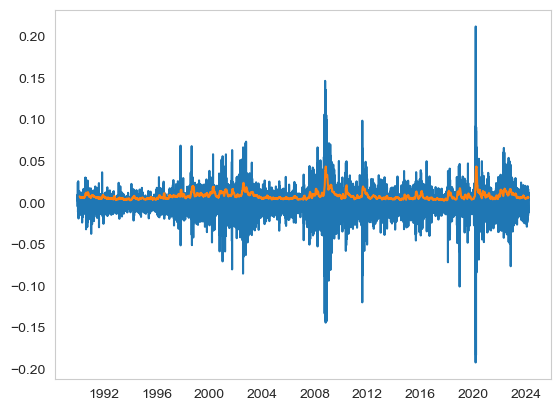

In [16]:
plt.plot(matrix['futures'].shift(1)[1:] - matrix['underline'][1:])
plt.plot(matrix['volatility'])
plt.grid(False)
plt.show()

In [17]:
matrix_models = matrix['2001':]

In [18]:
import warnings
warnings.filterwarnings('ignore')

matrix_models['market_expectation'] = matrix_models['futures'] - matrix_models['underline']
matrix_models.dropna(inplace = True)

In [19]:
import statsmodels.api as sm

X = matrix_models[['market_expectation']].shift(1)[1:]
X = sm.add_constant(X)
y = matrix_models['underline'][1:]

In [20]:
model = sm.OLS(y, X).fit()

In [21]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              underline   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.106
Date:                Tue, 19 Mar 2024   Prob (F-statistic):            0.00770
Time:                        18:58:18   Log-Likelihood:                 17418.
No. Observations:                5836   AIC:                        -3.483e+04
Df Residuals:                    5834   BIC:                        -3.482e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0003      0

OLS추정결과, p-value가 0에 거의 가깝게 나온다. $R^2$값이 0.001정도로 매우 낮긴 하지만, 전체 변동 중 0.001정도의 변동을 설명할 수 있는 요인이 될 수도 있다는 의미가 내포되어 있기 때문에 무시하기는 어렵다

#### Conclusion

시장의 기대를 선물과 index 증가율의 차로 계산한 것은 충분히 연구할만한 factor가 될 수도 있다

#### 생각해볼 만한 주제들

- Contango market, Back wardation market과 Regime은 어떤 관계가 있을까?
- 인과 검정을 할 수 있는 방법이 없을까?
- 만기에 다가올 수록 기초자산에 수렴하는데 이 기간동안 해석은 어떻게 해야할까?

#### ARMAX model

market expectation을 exogenous variable로 추가해 ARMA modeling을 수행하면 예측력이 더욱 좋아질까?

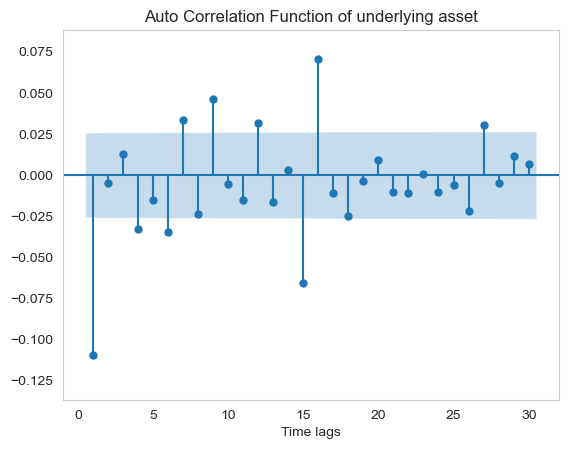

In [22]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(matrix_models['underline'], auto_ylims = True, lags = range(1, 31))
plt.grid(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function of underlying asset')
plt.show()

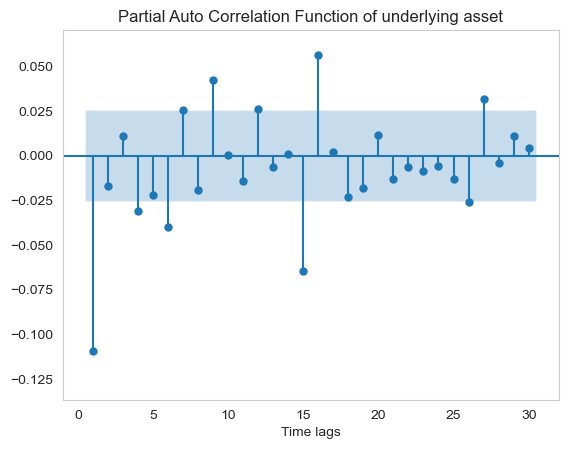

In [23]:
plot_pacf(matrix_models['underline'], auto_ylims = True, lags = range(1, 31))
plt.grid(False)
plt.xlabel('Time lags')
plt.title('Partial Auto Correlation Function of underlying asset')
plt.show()

In [145]:
model = sm.tsa.ARIMA(
    matrix_models['underline'][:'2023'], 
    order = (16,0,16), 
    trend = 'c'
).fit(method = 'innovations_mle')

In [146]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:              underline   No. Observations:                 5785
Model:               ARIMA(16, 0, 16)   Log Likelihood               17341.836
Date:                Tue, 19 Mar 2024   AIC                         -34615.672
Time:                        19:50:05   BIC                         -34389.130
Sample:                             0   HQIC                        -34536.856
                               - 5785                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.953      0.051   -9.92e-07       0.001
ar.L1         -0.1481      0.115     -1.293      0.196      -0.373       0.076
ar.L2         -0.5571      0.061     -9.125      0.0

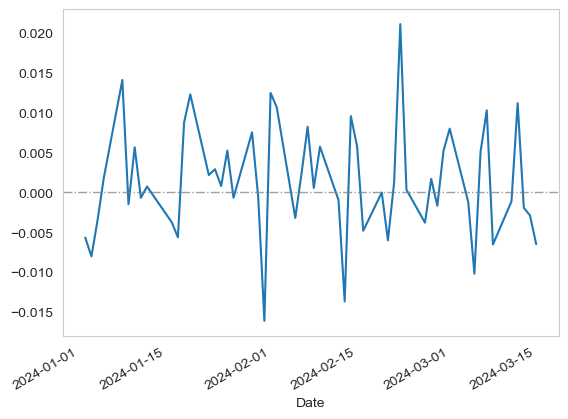

In [147]:
matrix['underline']['2024':].plot()
plt.grid(False)
plt.axhline(0, color = 'gray', linestyle = '-.', lw = 1, alpha = 0.75)
plt.show()

In [148]:
forecast_arma = pd.DataFrame(
    [
        model.forecast(steps = 52).values,
        model.get_forecast(steps = 52).conf_int()['lower underline'].values,
        model.get_forecast(steps = 52).conf_int()['upper underline'].values,
        model.get_forecast(steps = 52).conf_int(alpha = 0.01)['lower underline'].values,
        model.get_forecast(steps = 52).conf_int(alpha = 0.01)['upper underline'].values
    ],
    columns = matrix_models['underline']['2024':].index,
    index = ['forecast_mean', 'lower_bound', 'upper_bound', 'lower_bound2', 'upper_bound2']
).T

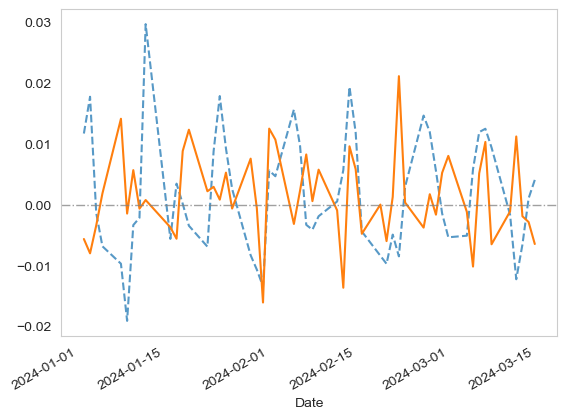

In [149]:
(forecast_arma['forecast_mean'] * 10).plot(alpha = 0.75, ls = '--')
matrix['underline']['2024':].plot()
plt.grid(False)
plt.axhline(0, color = 'gray', linestyle = '-.', lw = 1, alpha = 0.75)
plt.show()

ARMAX model

In [29]:
modelX = sm.tsa.ARIMA(
    endog = matrix_models['underline'][:'2023'], 
    exog = matrix_models['futures'][:'2023'],
    order = (16,0,16), 
    trend = 'c'
).fit(method = 'innovations_mle')

In [30]:
print(modelX.summary())

                               SARIMAX Results                                
Dep. Variable:              underline   No. Observations:                 5785
Model:               ARIMA(16, 0, 16)   Log Likelihood               27110.029
Date:                Tue, 19 Mar 2024   AIC                         -54150.058
Time:                        19:02:50   BIC                         -53916.852
Sample:                             0   HQIC                        -54068.924
                               - 5785                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.707e-06   3.61e-06      1.860      0.063   -3.61e-07    1.38e-05
futures        0.9866      0.001   1063.352      0.000       0.985       0.988
ar.L1         -0.3072      0.019    -16.207      0.0

In [31]:
forecast_armaX = pd.Series(
    model.forecast(steps = 52).values,
    index = matrix_models['underline']['2024':].index,
    name = 'forecast'
)

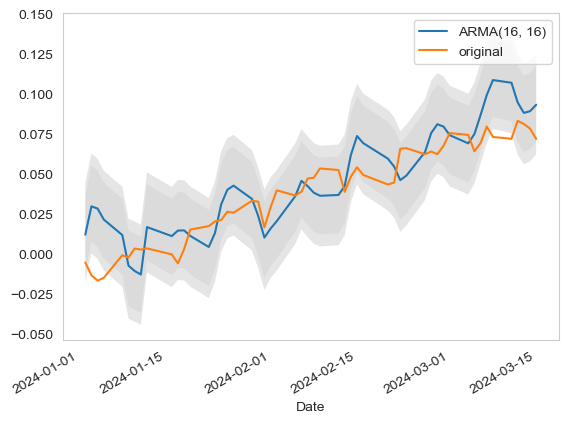

In [69]:
(forecast_arma['forecast_mean'] * 10).cumsum().plot(label = 'ARMA(16, 16)')
matrix_models['underline']['2024':].cumsum().plot(label = 'original')
plt.fill_between(
    forecast_arma.index, 
    forecast_arma['lower_bound'] + (forecast_arma['forecast_mean'] * 10).cumsum(), 
    forecast_arma['upper_bound'] + (forecast_arma['forecast_mean'] * 10).cumsum(), 
    color = 'gray', alpha = 0.1, edgecolor = 'none'
)
plt.fill_between(
    forecast_arma.index, 
    forecast_arma['lower_bound2'] + (forecast_arma['forecast_mean'] * 10).cumsum(), 
    forecast_arma['upper_bound2'] + (forecast_arma['forecast_mean'] * 10).cumsum(), 
    color = 'gray', alpha = 0.2, edgecolor = 'none'
)
plt.legend()
plt.grid(False)
plt.show()